In [1]:
import numpy as np
import scipy.io as sio
import numpy.matlib as npm
from scipy import signal
import pandas as pd
from numpy import linalg as LA
from scipy import linalg
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import argrelextrema
import time
from pynq import Overlay
from pynq import allocate

In [2]:
nop=200
dim_r = 1024
Nu_elements = 32 # Variable Number of Antenna
dim_c = Nu_elements
angles = 181
buffer_size = 2*dim_r*dim_c 
y_buffer_size = 2*angles*dim_r
angle_prec=1

In [3]:
class radar1:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 1.76*(10**9)
        self.L = 512
        self.PRI = 2*(10**-6)
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.PTM_len = nop
        self.Lambda = self.c/self.fc
        self.dfd = 121
        self.im_fdmax = 12*(10**3)
        self.im_fdmin = -12*(10**3)
        
class target:
    def __init__(self, range_t, doppler_velocity, rcs_amp):
        self.range = range_t
        self.doppler_velocity = doppler_velocity
        self.rcs_amp = rcs_amp
        self.n_bodypart = 1

class antenna:
    def __init__(self, Lambda, Nelements, DOA):
        self.d_m = Lambda * 0.5
        self.Nelements = Nelements
        self.spacing = np.arange(0, (self.Nelements) * self.d_m, self.d_m)
        self.DOA = DOA # Angle for azimuth

def get_received_signal(target, radar1, xmat1, fs, fc, antenna, n_frame):
    Mvec = radar1.PRI * np.arange(0,radar1.PTM_len)
    Marray = npm.repmat(Mvec, radar1.L, 1)
    radar1.ptx = 40
    radar1.gt = 0
    radar1.gr = 0
    rxmat = np.zeros((2*radar1.L, radar1.PTM_len), dtype=np.complex128)
    rxmat_temp = np.zeros((2*radar1.L-1, radar1.PTM_len), dtype=np.complex128)
    range_to_delay_symbols = np.floor(((2*target.range)/radar1.c)/radar1.ts)
    delay_zero = np.zeros((int(range_to_delay_symbols) - 1, int(radar1.PTM_len)))
    suffix_zero = np.zeros((int(radar1.L - range_to_delay_symbols), int(radar1.PTM_len)))
    
    # Range and doppler delay
    radar1.ptx_linear = (10**(radar1.ptx//10))*0.001
    radar1.gt_linear = (10**(radar1.gt//10))
    radar1.gr_linear = (10**(radar1.gr//10))
    radar1.radar_coeff=(np.sqrt(radar1.ptx_linear*radar1.gt_linear*radar1.gr_linear)*radar1.Lambda)/np.sqrt((4*np.pi)**3)   
    for nb in range(0,target.n_bodypart):
        velvec = target.doppler_velocity
        Doppler_ele = 2*np.pi*2*velvec/radar1.Lambda
        Doppler_Delay = np.exp(1j*(Doppler_ele*Marray))   
        temp = np.multiply(xmat1,Doppler_Delay)      
        amp = np.sqrt(target.rcs_amp)/(target.range ** 2)
        rxmat_temp = (amp*radar1.radar_coeff )*np.concatenate((delay_zero, temp, suffix_zero), dtype = np.complex128)
        rxmat[0:1023,:] = rxmat_temp

    # azimuth delay
    srx = np.zeros((2 * radar1.L, radar1.PTM_len, antenna.Nelements), dtype=np.complex128)
    lambda_m = radar1.Lambda
    antenna_matrix = np.exp(1j * 2 * np.pi * (1 / lambda_m) * np.sin(np.deg2rad(antenna.DOA)) * antenna.spacing)
    for p in range(radar1.PTM_len):
            srx[:, p, :] = np.matmul(np.transpose(rxmat[:, p][np.newaxis]),antenna_matrix[np.newaxis])
    srx_volts = np.transpose(srx, (0, 2, 1))
    return srx_volts


def get_max_y(y_res):
    y_antenna = np.transpose(y_res[0])
    win_hamm_col = np.hamming(181)
    awin_col = np.sum(win_hamm_col)
    power_music = 10*np.log10(np.abs(y_antenna[511:])/awin_col) + 18.706

    index_max = np.unravel_index(np.argmax(power_music, axis=None), power_music.shape)
    max_power = power_music[index_max]
    power_music[index_max] = power_music[index_max] + 5
    return max_power, power_music

In [4]:
def write_hardware_target(array, snr_db):
    #golden_data_t1 = open("./Results_FX/P200_Vd2_snr_"+str(snr_db)+".dat", "a")
    golden_data_t1 = open("./DPFL/Results_FX/P200_Vd2_snr_"+str(snr_db)+".dat", "a")
    array_line = ' '.join(map(str, array))
    golden_data_t1.write(array_line + "\n")
    golden_data_t1.close()
    
def write_golden_target(array):
    golden_data_t1 = open("./DPFL/Results_FX/V8_golden.dat", "a") # File to store all golden data
    array_line = ' '.join(map(str, array))
    golden_data_t1.write(array_line + "\n")
    golden_data_t1.close()

In [5]:
radar1_in = radar1()
doppler_axis = np.arange(radar1_in.im_fdmin, radar1_in.im_fdmax + radar1_in.dfd, radar1_in.dfd)
velocity_axis = doppler_axis * radar1_in.Lambda/2
delay_axis = np.arange(-radar1_in.L + 1, radar1_in.L)
range_axis = ((radar1_in.c * radar1_in.ts) / 2) * delay_axis
theta_axis = np.arange(-90, 91, 1)
# Load XMAT
tx = sio.loadmat("/home/xilinx/jupyter_notebooks/Aakanksha/V4/tx_freq_domain.mat")["xmat"]
xmat = np.transpose(np.transpose(tx)[:nop])
xmat1=xmat*np.squeeze(np.tile(np.exp(1j * np.pi * np.arange(4)/ 2),(1,int(xmat.shape[0] / 4)))).reshape(-1,1)
xmat_padded1 = np.zeros((1024, nop),np.complex128)
xmat_padded1[0:radar1_in.L,:] = xmat1
xmat_padded = np.zeros((Nu_elements, 1024, nop), dtype=np.complex128)
for i in range(Nu_elements):
    xmat_padded[i] = xmat_padded1
xmat_padded = np.transpose(xmat_padded, (2, 0, 1))
xmat_fft_conj_tran = np.zeros(shape=np.shape(xmat_padded), dtype=np.complex128)
for i in range(radar1_in.PTM_len):
    xmat_fft_conj_tran[i] = np.conj(np.fft.fft(xmat_padded[i]))
n_frame = 1

In [6]:
   # Adding doppler delay 
def add_doppler_delay(rxmat_fft, doppler_delay):
    return np.transpose([a*b for a,b in zip(rxmat_fft, doppler_delay)])

def select_theta(avg_pre):
    return np.arange(-90, 91, avg_pre)
    
    # Method for multiplication for Diagonal elements of matrix
def diag_mat_mul(rxmat_dd, xmat_conj):
    xmat_conj_trans = np.transpose(xmat_conj)
    diag_res2 = np.sum(np.multiply(rxmat_dd, xmat_conj_trans), axis = 1)
    return diag_res2
    
def dbf(rxmat_fft, azi_delay):
    rxmat_dd=np.transpose([a*b for a,b in zip(rxmat_fft, azi_delay)])
    diag_res2_sum=np.sum(rxmat_dd,axis=1)
    return diag_res2_sum
    
def matchedfiltering_angle_v4(rxmat_fft, xmat_fft_conj_tran,k,r_in,IDFT,avg_pre=1):
    if(r_in>=1024):
        r_in=1023
    theta = select_theta(avg_pre)
    y = np.zeros(shape=(radar1_in.PTM_len-1,), dtype=np.complex128)
    temp = np.zeros(shape=(1, 2 * radar1_in.L), dtype=np.complex128)
    for i in range(radar1_in.PTM_len-1):
        theta_k = (2 * np.pi * np.sin(np.pi * theta[k] / 180)) / radar1_in.Lambda
        azi_delay = np.exp(-1j * theta_k * antenna_param.spacing)
        out=dbf(rxmat_fft[i], azi_delay)
        out1=np.multiply(out,xmat_fft_conj_tran[i+1])
        y[i]=np.matmul(IDFT[r_in,:][np.newaxis],np.transpose(out1[np.newaxis]))/1024 
    return y

def matchedfiltering2D(total_srx_noise, xmat_fft_conj_tran, avg_pre=1):
    rxmat_fft = np.zeros(shape=np.shape(total_srx_noise), dtype=np.complex128)
    rxmat_fft = np.fft.fft(total_srx_noise)

    theta = select_theta(avg_pre)
    y = np.zeros(shape=( len(theta), 2 * radar1_in.L), dtype=np.complex128)
    for k in range(len(theta)):
        theta_k = (2 * np.pi * np.sin(np.pi * theta[k] / 180)) / radar1_in.Lambda
        azi_delay = np.exp(-1j * theta_k * antenna_param.spacing)
        out=dbf(rxmat_fft, azi_delay)
        out1=np.multiply(out,xmat_fft_conj_tran)
        y[k][:] = np.fft.ifftshift(np.fft.ifft(out1))
    return y, theta

In [7]:
def get_points_2d(N, Rmax):
    D = 2
    x = np.random.randn(N, D)
    Rmin = 1
    Rad = Rmax
    
    y = np.zeros((N, D))
    r = np.zeros(N)
    
    for n in range(N):
        dr = np.linalg.norm(x[n, :])
        U = np.random.random() ** (1 / D)
        y[n, :] = U * Rad * x[n, :] / dr
        r[n] = np.linalg.norm(y[n, :])
        
        if r[n] < Rmin:
            y[n, :] = np.full(D, np.finfo(float).tiny)
    
    x_coordinate = y[:, 0]
    y_coordinate = y[:, 1]
    
    return x_coordinate, y_coordinate

In [8]:
# Single Target SNR Performance
Nu_elements = 32 # Variable Number of Antenna
np.random.seed(1)
radar_pos = np.array([0, 0])
snr_db = 10
N = 200
Rmax = 40
x_coordinate, y_coordinate = get_points_2d(N, Rmax)

range1 = np.round(np.sqrt((radar_pos[0] - x_coordinate) ** 2 + (radar_pos[1] - y_coordinate) ** 2))
theta1 = np.round(np.rad2deg(np.arctan2(y_coordinate, x_coordinate)))
range1[range1 == 0] = 1
x_coordinate, y_coordinate = get_points_2d(N, Rmax)
theta1[(np.where(np.logical_and(theta1>=90, theta1<=180)))]=theta1[(np.where(np.logical_and(theta1>=90, theta1<=180)))]-180
theta1[(np.where(np.logical_and(theta1>=-180, theta1<=-90)))]=theta1[(np.where(np.logical_and(theta1>=-180, theta1<=-90)))]+180
vel1 = np.random.randint(-29, 21, size=N)
rcs1 = np.random.exponential(10, size=N)
vel2 = vel1 + 4 #### velocity difference for super-resolution
rcs2 = np.random.exponential(10, size=N)
vel3 = vel2 + 4 #### velocity difference for super-resolution
rcs3 = np.random.exponential(10, size=N)
theta1[theta1 > 85] = 85
theta1[theta1 < -85] = -85
rcs1[rcs1 == 0] = 1
rcs2[rcs2 == 0] = 1
rcs3[rcs3 == 0] = 1
r = np.transpose(np.vstack((range1)))
r1=range1
o1=theta1
v1=vel1
v2=vel2
v3=vel3
sigma1=rcs1
sigma2=rcs2
sigma3=rcs3

In [9]:
ol = Overlay("music_3.bit")
#ol = Overlay("MUSIC_FX_Givens.bit")
#ol = Overlay("/home/xilinx/jupyter_notebooks/AnkitKumarPal/SuperResolution/MUSIC/design_P200.bit")
data_channel = ol.axi_dma_0
import time
pltime = 0

pstime = 0

# Function to find peaks in spectrum
def find_local_maxima_indices(arr):
    maxima_indices = argrelextrema(arr, np.greater)
    local_maxima = list(zip(maxima_indices[0], arr[maxima_indices]))
    threshold = 0.75 * np.min(arr)
    local_maxima = [tup for tup in local_maxima if tup[1] >= threshold]

    if len(local_maxima) > 1:
        local_maxima = sorted(local_maxima, key=lambda x: x[1], reverse=True)
    if len(local_maxima) > 3:
        local_maxima = local_maxima[:3]
    
    pexx = [index for index, value in local_maxima]
    return np.array(pexx)
    
# Function to perfrom Autocorrelation
def autocorrelation_func(rec_sig):
    conj_sig = np.conj(rec_sig)
    autocorrelation_matrix = []
    for i in range(len(conj_sig)):
        dat1 = np.conj(conj_sig[i]) * rec_sig
        autocorrelation_matrix.append(dat1)
    return np.array(autocorrelation_matrix)
    
def subspace_gen(doppler_axis,N):
    subspace = np.zeros((1, N), dtype=np.complex128)
    for jj in range(N):
        subspace[0, jj] = np.exp(-1j*doppler_axis*jj)
    return subspace
        
# Function to generate rotation matrix
def givensrotation(a, b):
    z = a*a + b*b
    r = np.sqrt(z.real**2 + z.imag**2)
    theta = np.arctan2(z.imag, z.real)
    hypo = np.sqrt(r) * (np.cos(theta / 2) + 1j * np.sin(theta / 2))
    if hypo == 0:
        return 1, 0
    else:
        cos1 = a/ hypo
        sin1 = -b / hypo
        return cos1, sin1
    
# QR using Givens Rotation
def qr_givens(A):
    m, n = A.shape
    R = A.copy()
    Q = np.identity(m,dtype=np.complex128)
    for i in range(0, n - 1):
        for j in range(i + 1, m):
            cos, sin = givensrotation(R[i, i], R[j, i])
            R[i], R[j] = (R[i]*cos) + (R[j]*(-sin)), (R[i]*sin) + (R[j] * cos)
            Q[i], Q[j] = (Q[i]*cos) + (Q[j]*(-sin)), (Q[i]*sin) + (Q[j] * cos)
    return Q.T, R
    
# MUSIC using Given's Rotation
def music_PS(rec_signal):
    rec_signal = rec_signal.astype(np.complex128)
    N = len(rec_signal)
    l = N//2
    subarr=N+1-l
    autocorrelation_matrix = np.zeros((l, l), dtype=np.complex128)
    for i in range(subarr):
        sub1 = rec_signal[i:(l+i)]
        sub2 = autocorrelation_func(np.array(sub1))
        autocorrelation_matrix = autocorrelation_matrix+sub2
    autocorrelation_matrix = autocorrelation_matrix/subarr
    eign_vec, eign_val = qr_givens(autocorrelation_matrix)
    noise_subspace_est = np.delete(eign_vec, [0,1,2], axis=1)
    doppler_axis1=[-0.15079644737231,	-0.149275916527973,	-0.147755385683635,	-0.146234854839298,	-0.14471432399496,	-0.143193793150623,	-0.141673262306285,	-0.140152731461948,	-0.13863220061761,	-0.137111669773273,	-0.135591138928935,	-0.134070608084598,	-0.132550077240261,	-0.131029546395923,	-0.129509015551586,	-0.127988484707248,	-0.126467953862911,	-0.124947423018573,	-0.123426892174236,	-0.121906361329898,	-0.120385830485561,	-0.118865299641223,	-0.117344768796886,	-0.115824237952548,	-0.114303707108211,	-0.112783176263874,	-0.111262645419536,	-0.109742114575199,	-0.108221583730861,	-0.106701052886524,	-0.105180522042186,	-0.103659991197849,	-0.102139460353511,	-0.100618929509174,	-0.0990983986648364,	-0.097577867820499,	-0.0960573369761615,	-0.0945368061318241,	-0.0930162752874866,	-0.0914957444431491,	-0.0899752135988117,	-0.0884546827544742,	-0.0869341519101368,	-0.0854136210657993,	-0.0838930902214618,	-0.0823725593771244,	-0.0808520285327869,	-0.0793314976884495,	-0.077810966844112,	-0.0762904359997745,	-0.0747699051554371,	-0.0732493743110996,	-0.0717288434667622,	-0.0702083126224247,	-0.0686877817780872,	-0.0671672509337498,	-0.0656467200894123,	-0.0641261892450749,	-0.0626056584007374,	-0.0610851275563999,	-0.0595645967120625,	-0.058044065867725,	-0.0565235350233876,	-0.0550030041790501,	-0.0534824733347126,	-0.0519619424903752,	-0.0504414116460377,	-0.0489208808017003,	-0.0474003499573628,	-0.0458798191130253,	-0.0443592882686879,	-0.0428387574243504,	-0.041318226580013,	-0.0397976957356755,	-0.038277164891338,	-0.0367566340470006,	-0.0352361032026631,	-0.0337155723583257,	-0.0321950415139882,	-0.0306745106696507,	-0.0291539798253133,	-0.0276334489809758,	-0.0261129181366384,	-0.0245923872923009,	-0.0230718564479634,	-0.021551325603626,	-0.0200307947592885,	-0.0185102639149511,	-0.0169897330706136,	-0.0154692022262761,	-0.0139486713819387,	-0.0124281405376012,	-0.0109076096932638,	-0.0093870788489263,	-0.00786654800458884,	-0.00634601716025138,	-0.00482548631591392,	-0.00330495547157646,	-0.001784424627239,	-0.000263893782901543,	0.00125663706143592,	0.00277716790577338,	0.00429769875011084,	0.0058182295944483,	0.00733876043878576,	0.00885929128312322,	0.0103798221274607,	0.0119003529717981,	0.0134208838161356,	0.0149414146604731,	0.0164619455048105,	0.017982476349148,	0.0195030071934854,	0.0210235380378229,	0.0225440688821604,	0.0240645997264978,	0.0255851305708353,	0.0271056614151727,	0.0286261922595102,	0.0301467231038477,	0.0316672539481851,	0.0331877847925226,	0.03470831563686,	0.0362288464811975,	0.037749377325535,	0.0392699081698724,	0.0407904390142099,	0.0423109698585473,	0.0438315007028848,	0.0453520315472223,	0.0468725623915597,	0.0483930932358972,	0.0499136240802346,	0.0514341549245721,	0.0529546857689096,	0.054475216613247,	0.0559957474575845,	0.0575162783019219,	0.0590368091462594,	0.0605573399905969,	0.0620778708349343,	0.0635984016792718,	0.0651189325236092,	0.0666394633679467,	0.0681599942122841,	0.0696805250566216,	0.0712010559009591,	0.0727215867452965,	0.074242117589634,	0.0757626484339714,	0.0772831792783089,	0.0788037101226464,	0.0803242409669838,	0.0818447718113213,	0.0833653026556587,	0.0848858334999962,	0.0864063643443337,	0.0879268951886711,	0.0894474260330086,	0.0909679568773461,	0.0924884877216835,	0.094009018566021,	0.0955295494103584,	0.0970500802546959,	0.0985706110990334,	0.100091141943371,	0.101611672787708,	0.103132203632046,	0.104652734476383,	0.106173265320721,	0.107693796165058,	0.109214327009396,	0.110734857853733,	0.11225538869807,	0.113775919542408,	0.115296450386745,	0.116816981231083,	0.11833751207542,	0.119858042919758,	0.121378573764095,	0.122899104608433,	0.12441963545277,	0.125940166297108,	0.127460697141445,	0.128981227985783,	0.13050175883012,	0.132022289674457,	0.133542820518795,	0.135063351363132,	0.13658388220747,	0.138104413051807,	0.139624943896145,	0.141145474740482,	0.14266600558482,	0.144186536429157,	0.145707067273495,	0.147227598117832,	0.14874812896217,	0.150268659806507,	0.151789190650844]
    p_music = []
    for i in range(len(doppler_axis)):
        subspace = subspace_gen(doppler_axis1[i],l)
        ss1_nn1 = np.matmul(subspace, noise_subspace_est)
        peak1 = np.sum(ss1_nn1.real**2) + np.sum(ss1_nn1.imag**2)
        p_music.append(peak1)
    #print("PS output")
    t=np.min(p_music)/p_music
    #for i in range(len(t)):
    #    print(t[i],",")
    p_music = np.flip(np.array(p_music))
    p_music = 10*np.log10(np.min(p_music)/p_music)
    A1 = find_local_maxima_indices(p_music)
    if len(A1) == 0:
        velx1 = [30.0, 30.0, 30.0]
    elif (len(A1) == 2):
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
        
    elif len(A1) == 1:
        velocity_axis = np.linspace(-30, 30, 200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
        velx1.append(0)
        
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
    return velx1[0], velx1[1], velx1[2], t

# MUSIC using QR Library
def music_PS_QR(rec_signal):
    rec_signal = rec_signal.astype(np.complex64)
    N = len(rec_signal)
    l = N//2
    subarr=N+1-l
    autocorrelation_matrix = np.zeros((l, l), dtype=np.complex64)
    for i in range(subarr):
        sub1 = rec_signal[i:(l+i)]
        sub2 = autocorrelation_func(np.array(sub1))
        autocorrelation_matrix = autocorrelation_matrix+sub2
    autocorrelation_matrix = autocorrelation_matrix/subarr
    eign_vec, eign_val = np.linalg.qr(autocorrelation_matrix,mode='complete')
    noise_subspace_est = np.delete(eign_vec, [0,1], axis=1)
    print(sub1.dtype,sub2.dtype,autocorrelation_matrix.dtype,noise_subspace_est.dtype,eign_vec.dtype,eign_val.dtype,noise_subspace_est.shape )
    doppler_axis1=[-0.15079644737231,	-0.149275916527973,	-0.147755385683635,	-0.146234854839298,	-0.14471432399496,	-0.143193793150623,	-0.141673262306285,	-0.140152731461948,	-0.13863220061761,	-0.137111669773273,	-0.135591138928935,	-0.134070608084598,	-0.132550077240261,	-0.131029546395923,	-0.129509015551586,	-0.127988484707248,	-0.126467953862911,	-0.124947423018573,	-0.123426892174236,	-0.121906361329898,	-0.120385830485561,	-0.118865299641223,	-0.117344768796886,	-0.115824237952548,	-0.114303707108211,	-0.112783176263874,	-0.111262645419536,	-0.109742114575199,	-0.108221583730861,	-0.106701052886524,	-0.105180522042186,	-0.103659991197849,	-0.102139460353511,	-0.100618929509174,	-0.0990983986648364,	-0.097577867820499,	-0.0960573369761615,	-0.0945368061318241,	-0.0930162752874866,	-0.0914957444431491,	-0.0899752135988117,	-0.0884546827544742,	-0.0869341519101368,	-0.0854136210657993,	-0.0838930902214618,	-0.0823725593771244,	-0.0808520285327869,	-0.0793314976884495,	-0.077810966844112,	-0.0762904359997745,	-0.0747699051554371,	-0.0732493743110996,	-0.0717288434667622,	-0.0702083126224247,	-0.0686877817780872,	-0.0671672509337498,	-0.0656467200894123,	-0.0641261892450749,	-0.0626056584007374,	-0.0610851275563999,	-0.0595645967120625,	-0.058044065867725,	-0.0565235350233876,	-0.0550030041790501,	-0.0534824733347126,	-0.0519619424903752,	-0.0504414116460377,	-0.0489208808017003,	-0.0474003499573628,	-0.0458798191130253,	-0.0443592882686879,	-0.0428387574243504,	-0.041318226580013,	-0.0397976957356755,	-0.038277164891338,	-0.0367566340470006,	-0.0352361032026631,	-0.0337155723583257,	-0.0321950415139882,	-0.0306745106696507,	-0.0291539798253133,	-0.0276334489809758,	-0.0261129181366384,	-0.0245923872923009,	-0.0230718564479634,	-0.021551325603626,	-0.0200307947592885,	-0.0185102639149511,	-0.0169897330706136,	-0.0154692022262761,	-0.0139486713819387,	-0.0124281405376012,	-0.0109076096932638,	-0.0093870788489263,	-0.00786654800458884,	-0.00634601716025138,	-0.00482548631591392,	-0.00330495547157646,	-0.001784424627239,	-0.000263893782901543,	0.00125663706143592,	0.00277716790577338,	0.00429769875011084,	0.0058182295944483,	0.00733876043878576,	0.00885929128312322,	0.0103798221274607,	0.0119003529717981,	0.0134208838161356,	0.0149414146604731,	0.0164619455048105,	0.017982476349148,	0.0195030071934854,	0.0210235380378229,	0.0225440688821604,	0.0240645997264978,	0.0255851305708353,	0.0271056614151727,	0.0286261922595102,	0.0301467231038477,	0.0316672539481851,	0.0331877847925226,	0.03470831563686,	0.0362288464811975,	0.037749377325535,	0.0392699081698724,	0.0407904390142099,	0.0423109698585473,	0.0438315007028848,	0.0453520315472223,	0.0468725623915597,	0.0483930932358972,	0.0499136240802346,	0.0514341549245721,	0.0529546857689096,	0.054475216613247,	0.0559957474575845,	0.0575162783019219,	0.0590368091462594,	0.0605573399905969,	0.0620778708349343,	0.0635984016792718,	0.0651189325236092,	0.0666394633679467,	0.0681599942122841,	0.0696805250566216,	0.0712010559009591,	0.0727215867452965,	0.074242117589634,	0.0757626484339714,	0.0772831792783089,	0.0788037101226464,	0.0803242409669838,	0.0818447718113213,	0.0833653026556587,	0.0848858334999962,	0.0864063643443337,	0.0879268951886711,	0.0894474260330086,	0.0909679568773461,	0.0924884877216835,	0.094009018566021,	0.0955295494103584,	0.0970500802546959,	0.0985706110990334,	0.100091141943371,	0.101611672787708,	0.103132203632046,	0.104652734476383,	0.106173265320721,	0.107693796165058,	0.109214327009396,	0.110734857853733,	0.11225538869807,	0.113775919542408,	0.115296450386745,	0.116816981231083,	0.11833751207542,	0.119858042919758,	0.121378573764095,	0.122899104608433,	0.12441963545277,	0.125940166297108,	0.127460697141445,	0.128981227985783,	0.13050175883012,	0.132022289674457,	0.133542820518795,	0.135063351363132,	0.13658388220747,	0.138104413051807,	0.139624943896145,	0.141145474740482,	0.14266600558482,	0.144186536429157,	0.145707067273495,	0.147227598117832,	0.14874812896217,	0.150268659806507,	0.151789190650844]
    p_music = []
    for i in range(len(doppler_axis)):
        subspace = subspace_gen(doppler_axis1[i],l)
        ss1_nn1 = np.matmul(subspace, noise_subspace_est)
        peak1 = np.sum(ss1_nn1.real**2) + np.sum(ss1_nn1.imag**2)
        p_music.append(peak1)
    #print("PS output")
    t=np.min(p_music)/p_music
    #for i in range(len(t)):
    #    print(t[i],",")
    p_music = np.array(p_music)
    p_music = 10*np.log10(np.min(p_music)/p_music)
    A1 = find_local_maxima_indices(p_music)
    if len(A1) == 0:
        velx1 = [30.0, 30.0, 30.0]
        
    elif len(A1) == 1:
        velocity_axis = np.linspace(-30, 30, 200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
        velx1.append(0)
    elif (len(A1) == 2):
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
    return velx1[0], velx1[1], velx1[2], t


def music1(rec_signal1):
    input_buffer = allocate((nop,),np.cdouble)
    output_buffer = allocate((200,),np.single)
    
    send_channel = data_channel.sendchannel
    recv_channel = data_channel.recvchannel
    
    np.copyto(input_buffer,rec_signal1)

    send_channel.transfer(input_buffer)
    recv_channel.transfer(output_buffer)
    send_channel.wait()
    recv_channel.wait()
    #print("PL output")
    #print(output_buffer)
    peaks1 = 10*np.log10(np.abs(np.flip((output_buffer))))
    return peaks1,output_buffer


def music_PL(rec_signal1):
    p_music,ob = music1(rec_signal1)
    
    while(np.isnan(p_music[0])):
        rec_signal1 = rec_signal1 * 3.1622776602/2
        p_music,ob = music1(rec_signal1)
        print("nan detected")
        
    A1 = find_local_maxima_indices(p_music)
    
    #if len(A1) < 3:
     #   print(f" Only {len(A1)} peaks found.")
    if len(A1) == 0:
        velx1 = [30.0, 30.0, 30.0]
        
    elif len(A1) == 1:
        velocity_axis = np.linspace(-30, 30, 200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
        velx1.append(0)
    elif (len(A1) == 2):
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)
        velx1.append(0)
    else:
        velocity_axis = np.linspace(-30,30,200)
        velx1 = velocity_axis[A1].tolist()
        velx1.sort(reverse=True)

    return velx1[0], velx1[1], velx1[2], ob

def MUSIC_F(rec_signal1):
    #print("INPUT")
    #print(np.real(rec_signal1))
    #print(np.imag(rec_signal1))
    
    start_time = time.time()
    [vx1, vx2,vx3, p_music_PS] = music_PS(rec_signal1)
    finish_time = time.time()
    pstime = finish_time - start_time
    print(f"PS Time = {pstime}")
    
    start_time = time.time()
    vx4, vx5, vx6, p_music_PL = music_PL(rec_signal1)
    finish_time = time.time()
    pltime = finish_time - start_time
    print(f"PL Time = {pltime}") 
    
    acc_fac = pstime/pltime
    print(f"Acceleration factor = {acc_fac}")
    #vx3, vx4, p_music_PL = music_PS_QR(rec_signal1)
    return vx1, vx2, vx3, vx4, vx5, vx6, p_music_PL, p_music_PS, acc_fac

In [10]:
p_music_PL=np.zeros((12,200,200))
p_music_PS=np.zeros((12,200,200))
p_acc_fac = np.zeros((12, 200))
acc_fac_avg = 0
music_input=np.zeros((12,200,nop),'complex128')
s=0
for j in range(40):
    N=5
    snr_db = 10
    signal_power = np.zeros(N)
    srx_volts = np.zeros((N, radar1_in.PTM_len, Nu_elements, 2 * radar1_in.L), dtype=np.complex128)
    srx_noise = np.zeros((N, radar1_in.PTM_len, Nu_elements, 2 * radar1_in.L), dtype=np.complex128)
    rxmat_fft = np.zeros(shape=np.shape(srx_noise[1:,:,:]), dtype=np.complex128)
    n1 = 1024
    w1 = np.exp(-1j * 2 * np.pi / n1)
    I, J = np.meshgrid(np.arange(1, n1 + 1), np.arange(1, n1 + 1))
    DFT1 = w1**((I - 1) * (J - 1))
    IDFT = np.transpose(np.conj(DFT1))
    mean_signal_power=(10*32*1*(0.005**2)*1)/(((4*np.pi)**3)*(40**4))
    print("Round: " + str(j))
    for snr_db in [-15,-10,-5,0,5,10,15,20,25,30,35,40]:
        acc_fac_avg = 0
    #for snr_db in [40]:
        print("SNR:", snr_db)
        snr_linear = 10 ** (snr_db/10)
        noise_power = mean_signal_power/snr_linear
        for i in range(j*N,(j+1)*N):
            range_t=r1[i];
            velocity1=v1[i];
            velocity2=v2[i];
            velocity3=v3[i];
            rcs_amp1=sigma1[i];
            rcs_amp2=sigma2[i];
            rcs_amp3=sigma3[i];
            DOA_angle=o1[i];
            rcs_t = [rcs_amp1,rcs_amp2,rcs_amp3]
            vel_t = [velocity1,velocity2,velocity3]
            vel = list(zip(vel_t,rcs_t))
            vel = sorted(vel, key=lambda x: x[1], reverse=True)
            vel_x = [t[0] for t in vel]
            write_golden_target(vel_x)
            t1 = target(range_t, velocity1, rcs_amp1)
            t2 = target(range_t, velocity2, rcs_amp2) 
            t3 = target(range_t, velocity3, rcs_amp3)
            antenna_param = antenna(radar1_in.Lambda, Nu_elements, DOA_angle)
            rxmat_t1 = get_received_signal(t1, 
                                            radar1_in, 
                                            xmat1, 
                                            radar1_in.fs, 
                                            radar1_in.fc, 
                                            antenna_param, 
                                            n_frame)

            rxmat_t2 = get_received_signal(t2, 
                                            radar1_in, 
                                            xmat1, 
                                            radar1_in.fs, 
                                            radar1_in.fc, 
                                            antenna_param, 
                                            n_frame)
            rxmat_t3 = get_received_signal(t3, 
                                            radar1_in, 
                                            xmat1, 
                                            radar1_in.fs, 
                                            radar1_in.fc, 
                                            antenna_param, 
                                            n_frame)
            rxmat_t123 = rxmat_t1 + rxmat_t2 + rxmat_t3
            srx_volts = np.transpose(rxmat_t123, (2, 1, 0))
            noise = np.sqrt(noise_power) * (np.random.randn(srx_volts.shape[0],srx_volts.shape[1],srx_volts.shape[2]) + (1j * np.random.randn(srx_volts.shape[0],srx_volts.shape[1],srx_volts.shape[2])))
            srx_noise = srx_volts + noise
            rxmat_fft = np.fft.fft(srx_noise[1:,:,:])
            
            y_pack1 = np.zeros(shape=(radar1_in.PTM_len,), dtype=np.complex128)
            y_p1 = np.zeros(shape=(radar1_in.PTM_len-1,), dtype=np.complex128)
            
            y_res, theta = matchedfiltering2D(srx_noise[0,:,:], xmat_fft_conj_tran[0,0,:], avg_pre=angle_prec) 
            [a1, b1] = np.unravel_index(np.argmax(np.abs(y_res)), y_res.shape)
            mf_t1=y_res[a1,b1]
            if(b1<=512):
                b1_new=b1+512
            else:
                b1_new=b1-512
            y_p1 = matchedfiltering_angle_v4(rxmat_fft, xmat_fft_conj_tran[:,0,:],a1,b1_new,IDFT)
            y_pack1[1:radar1_in.PTM_len]=y_p1
            y_pack1[0]=mf_t1
            music_in1=y_pack1
            music_in = music_in1.flatten()
            music_input[s,i,:]=music_in
            acc_fac_temp = 0
            vx1, vx2, vx3, vx4,vx5,vx6, p_music_PL[s,i,:], p_music_PS[s,i,:], p_acc_fac[s,i]= MUSIC_F(music_in)
            #vx1, vx2, vx3, vx4, vx5, vx6, p_music_PL[s,i,:], p_music_PS[s,i,:]= MUSIC_F(music_in)
            acc_fac_avg += p_acc_fac[s,i]
            hw = np.array([velocity3,velocity2,velocity1, vx1, vx2, vx3, vx4, vx5, vx6])
            write_hardware_target(hw, snr_db)
            #print(s,i)
            #print(hw)
         
        s=s+1
        acc_fac_avg /= 5
        
        #print(f"Average acceleration factor over 5 runs for SNR = {snr_db} is {acc_fac_avg}")
    s=0

Round: 0
SNR: -15
PS Time = 2.1488592624664307
PL Time = 0.08703136444091797
Acceleration factor = 24.69063051315487
PS Time = 2.183295965194702
PL Time = 0.0832827091217041
Acceleration factor = 26.21547723674756
PS Time = 2.209650993347168
PL Time = 0.0819392204284668
Acceleration factor = 26.96695162332183
PS Time = 2.7366995811462402
PL Time = 0.08381128311157227
Acceleration factor = 32.65311637698063
PS Time = 2.1733627319335938
PL Time = 0.0792851448059082
Acceleration factor = 27.411979094621497
Average acceleration factor over 5 runs for SNR = -15 is 27.58763096896528
SNR: -10
PS Time = 2.167813539505005
PL Time = 0.07925963401794434
Acceleration factor = 27.35078916733596
PS Time = 2.199216365814209
PL Time = 0.07889676094055176
Acceleration factor = 27.87460904093776
PS Time = 2.1651997566223145
PL Time = 0.07991170883178711
Acceleration factor = 27.094899962407585
PS Time = 2.231283664703369
PL Time = 0.07826566696166992
Acceleration factor = 28.509099217107867
PS Time = 2.

In [11]:
import scipy.io as sio
sio.savemat('FX_p_music_PL_3_200.mat',{'FX_p_music_PL':p_music_PL})
sio.savemat('FX_p_music_PS_3_200.mat',{'FX_p_music_PS':p_music_PS})
sio.savemat('FX_music_input_3_200.mat',{'FX_music_input':music_input})

In [13]:
p_music_PL=sio.loadmat("FX_p_music_PL_3_200.mat")["FX_p_music_PL"]

In [14]:
np.shape(p_music_PL)
p_music_PL[11,4,:]
#p_music_PS[6,3,:]
#np.imag(music_input[11,5,:])

array([4.34490248e-05, 5.65716909e-05, 7.50494437e-05, 1.01731246e-04,
       1.41418204e-04, 2.02578754e-04, 3.01016495e-04, 4.68368904e-04,
       7.74024695e-04, 1.39023468e-03, 2.82871933e-03, 7.11768679e-03,
       2.84229238e-02, 1.00000000e+00, 1.09094426e-01, 2.63595190e-02,
       1.39312912e-02, 9.94809531e-03, 8.44273623e-03, 8.10127798e-03,
       8.61245114e-03, 1.01009142e-02, 1.31920381e-02, 1.97217967e-02,
       3.59933414e-02, 9.50360894e-02, 6.91081762e-01, 5.38398564e-01,
       8.54198709e-02, 3.37823927e-02, 1.88937951e-02, 1.28017794e-02,
       9.89971031e-03, 8.51787999e-03, 8.09121691e-03, 8.53578653e-03,
       1.02326479e-02, 1.47292707e-02, 2.92806961e-02, 1.26126438e-01,
       1.51081681e-01, 1.82882063e-02, 5.41370874e-03, 2.28010351e-03,
       1.15151296e-03, 6.50286209e-04, 3.96422925e-04, 2.55625462e-04,
       1.72132990e-04, 1.19997778e-04, 8.60713699e-05, 6.32334995e-05,
       4.74169647e-05, 3.61946331e-05, 2.80632921e-05, 2.20623897e-05,
      

In [15]:
p_music_PS[11,4,:]

array([1.71708544e-04, 2.22626493e-04, 2.94265378e-04, 3.97667629e-04,
       5.51470958e-04, 7.88627577e-04, 1.17079969e-03, 1.82188325e-03,
       3.01487250e-03, 5.43132919e-03, 1.11083012e-02, 2.81364375e-02,
       1.10676126e-01, 1.00000000e+00, 2.54965728e-01, 8.25802910e-02,
       4.65283606e-02, 3.40056869e-02, 2.90967738e-02, 2.79025337e-02,
       2.94079564e-02, 3.38361518e-02, 4.25822771e-02, 5.91143238e-02,
       9.13358753e-02, 1.53174047e-01, 2.29230057e-01, 2.05959053e-01,
       1.23696583e-01, 7.24416146e-02, 4.65450165e-02, 3.29220025e-02,
       2.52554378e-02, 2.07249850e-02, 1.79982991e-02, 1.63924759e-02,
       1.55111744e-02, 1.50563211e-02, 1.46999106e-02, 1.40148020e-02,
       1.25856980e-02, 1.03598072e-02, 7.81277601e-03, 5.53698617e-03,
       3.81004328e-03, 2.61037364e-03, 1.80709016e-03, 1.27291999e-03,
       9.14657928e-04, 6.70572902e-04, 5.01179001e-04, 3.81367253e-04,
       2.95048114e-04, 2.31767010e-04, 1.84617405e-04, 1.48956885e-04,
      

0


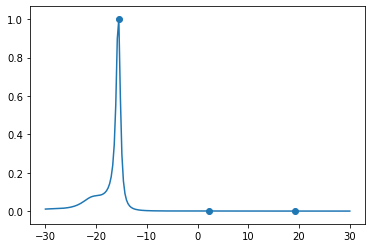

[-15.52763819   2.26130653  19.14572864]
1


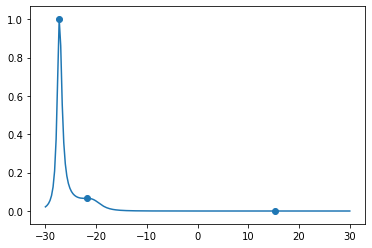

[-27.28643216 -21.85929648  15.22613065]
2


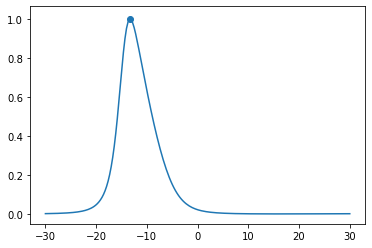

[-13.41708543]
3


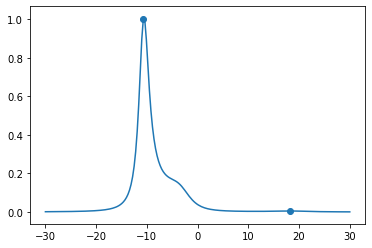

[-10.70351759  18.24120603]
4


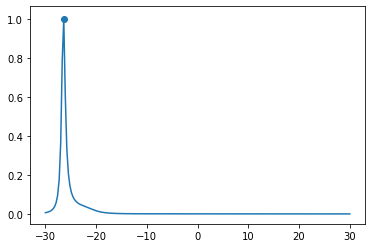

[-26.38190955]


In [16]:
#Display PL
import matplotlib.pyplot as plt
velocity_axis = np.linspace(-30,30,200)
for i in range(5):
    print(i);
    vec=p_music_PL[0,i,:]
    peaks=find_local_maxima_indices(vec)
    plt.figure()
    plt.plot(velocity_axis,vec)
    plt.scatter(velocity_axis[peaks],vec[peaks])
    plt.show()
    print(velocity_axis[peaks])
    a=p_music_PL[2,i,:]
    for j in range(199):
        if(a[j]==a[j+1] and a[j]>0.005):
            print(a[j],a[j+1],velocity_axis[j],velocity_axis[j+1])
            print(p_music_PL[10,i,:])

0


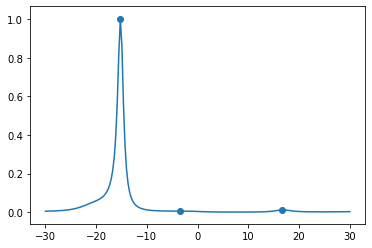

[-15.22613065  16.73366834  -3.46733668]
1


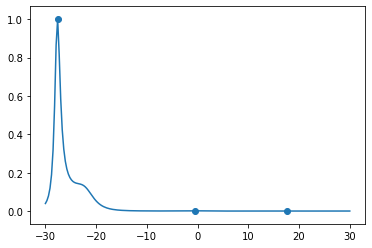

[-27.5879397   -0.45226131  17.63819095]
2


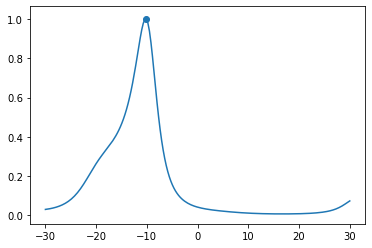

[-10.10050251]
3


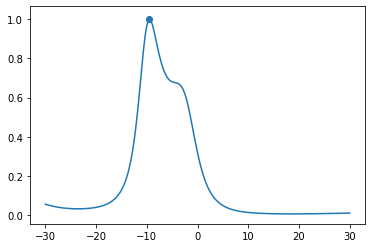

[-9.49748744]
4


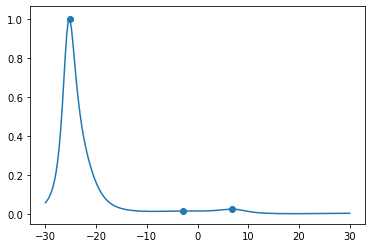

[-25.1758794    6.7839196   -2.86432161]


In [17]:
#Display PS
velocity_axis = np.linspace(-30,30,200)
for i in range(5):
    print(i);
    vec=p_music_PS[0,i,:]
    peaks=find_local_maxima_indices(vec)
    plt.figure()
    plt.plot(velocity_axis,vec)
    plt.scatter(velocity_axis[peaks],vec[peaks])
    plt.show()
    print(velocity_axis[peaks])

In [18]:
p_music_PS[11,4,:]

array([1.71708544e-04, 2.22626493e-04, 2.94265378e-04, 3.97667629e-04,
       5.51470958e-04, 7.88627577e-04, 1.17079969e-03, 1.82188325e-03,
       3.01487250e-03, 5.43132919e-03, 1.11083012e-02, 2.81364375e-02,
       1.10676126e-01, 1.00000000e+00, 2.54965728e-01, 8.25802910e-02,
       4.65283606e-02, 3.40056869e-02, 2.90967738e-02, 2.79025337e-02,
       2.94079564e-02, 3.38361518e-02, 4.25822771e-02, 5.91143238e-02,
       9.13358753e-02, 1.53174047e-01, 2.29230057e-01, 2.05959053e-01,
       1.23696583e-01, 7.24416146e-02, 4.65450165e-02, 3.29220025e-02,
       2.52554378e-02, 2.07249850e-02, 1.79982991e-02, 1.63924759e-02,
       1.55111744e-02, 1.50563211e-02, 1.46999106e-02, 1.40148020e-02,
       1.25856980e-02, 1.03598072e-02, 7.81277601e-03, 5.53698617e-03,
       3.81004328e-03, 2.61037364e-03, 1.80709016e-03, 1.27291999e-03,
       9.14657928e-04, 6.70572902e-04, 5.01179001e-04, 3.81367253e-04,
       2.95048114e-04, 2.31767010e-04, 1.84617405e-04, 1.48956885e-04,
      

In [19]:
p_acc_fac

array([[24.69063051, 26.21547724, 26.96695162, ..., 25.69335949,
        26.61727614, 25.76113742],
       [27.35078917, 27.87460904, 27.09489996, ..., 26.44000944,
        25.53653538, 25.69462937],
       [34.56508287, 26.74468956, 27.89757845, ..., 26.09996975,
        25.59820074, 25.99731679],
       ...,
       [25.35217274, 26.06758307, 25.92413374, ..., 25.0512096 ,
        25.53788253, 25.68589169],
       [26.57433436, 26.44899748, 26.26543166, ..., 26.00587729,
        26.95683092, 25.69430086],
       [26.32751514, 26.20021382, 26.04595012, ..., 25.79627134,
        26.14524434, 26.52573319]])

In [20]:
np.mean(p_acc_fac)

26.070062053755237